In [25]:
from pathlib import Path

data_dir = Path.cwd() / "data"
assert data_dir.exists(), f"Data directory does not exist: {data_dir}"

In [26]:
import json
from enum import Enum

import numpy as np
import h5py

import torch
import torchmetrics
from lightning.pytorch import LightningDataModule, LightningModule, Trainer
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import wandb

from matplotlib import pyplot as plt
import seaborn as sns
from cmap import Colormap

In [27]:
# Seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.use_deterministic_algorithms(True)

torch.set_float32_matmul_precision("medium")

In [28]:
# Set larger font sizes for presentations
sns.set_context('talk')

# Set colorblind-friendly Okabe-Ito palette globally
cm_mpl = Colormap('okabeito:okabeito').to_mpl()
okabe_ito_colors = [cm_mpl(i / 7)
                    for i in range(8)]  # Extract 8 distinct colors
sns.set_style('whitegrid')
sns.set_palette(okabe_ito_colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=okabe_ito_colors)

# Set serif font LAST to ensure it's not overwritten
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [29]:
wandb.login()

True

In [30]:
# Load channel mapping from central config file
with open("channel_config.json", "r") as f:
    _config = json.load(f)
    CHANNEL_MAPPING = _config["channel_mapping"]
    DIRECT_CHANNELS = _config["channel_groups"]["DIRECT"]
    INDIRECT_CHANNELS = _config["channel_groups"]["INDIRECT"]
    ALL_CHANNELS = _config["channel_groups"]["ALL"]


class ClassificationTarget(Enum):
    DeepDrawing = "Deep Drawing"
    Ironing = "Ironing"
    Both = "Deep Drawing and Ironing"

In [31]:
# Parameters cell for papermill
# These values will be overridden by papermill when running experiments
data_path = "all_data.hdf5"
signal_only_channels = [1]
classification_target = "Ironing"
plot_path = None  # Will be set below if None
wandb_group = None  # Optional WandB group name for organizing experiments

In [32]:
# Configuration - uses parameters from papermill or defaults from parameters cell
from pathlib import Path
import ast

# Convert signal_only_channels if it's a string (from shell parameter)
if isinstance(signal_only_channels, str):
    signal_only_channels = ast.literal_eval(signal_only_channels)

# Convert data_path to Path object
if not isinstance(data_path, Path):
    if Path(data_path).is_absolute():
        data_path = Path(data_path)
    else:
        data_path = data_dir / data_path

# Get readable channel names
signal_only_channels_readable = [
    CHANNEL_MAPPING[list(CHANNEL_MAPPING.keys())[i]] for i in signal_only_channels]

# Convert classification_target string to enum
if isinstance(classification_target, str):
    classification_target = ClassificationTarget[classification_target]

# Set plot_path if not provided
if plot_path is None:
    plot_path = data_path.parents[1] / "plots" / \
        f"{classification_target.value}-from-{','.join(signal_only_channels_readable)}"
elif not isinstance(plot_path, Path):
    plot_path = Path(plot_path)

print("Configuration:")
print(f"  data_path: {data_path}")
print(f"  signal_only_channels: {signal_only_channels} ({repr(signal_only_channels_readable)})")
print(f"  classification_target: {classification_target.value}")
print(f"  plot_path: {plot_path.absolute()}")

# Create plot directory if it doesn't exist
plot_path.mkdir(parents=True, exist_ok=True)

Configuration:
  data_path: /workspaces/sheet-metal-forming-measurement-comparison/data/all_data.hdf5
  signal_only_channels: [1] (['Strip Connection Cut (Direct)'])
  classification_target: Ironing
  plot_path: /workspaces/sheet-metal-forming-measurement-comparison/plots/Ironing-from-Strip Connection Cut (Direct)


In [33]:
class SheetMetalDataset(torch.utils.data.Dataset):
    """Dataset for sheet metal forming measurements."""

    def __init__(self, data: np.ndarray, metadata: dict):
        """
        Args:
            data: Array of shape (n_entries, n_signals, n_points)
            metadata: Dict with Deep Drawing, Ironing arrays
        """
        self.data = torch.from_numpy(data).float()
        self.deep_drawing = torch.from_numpy(metadata["Deep Drawing"]).long()-1
        self.ironing = torch.from_numpy(metadata["Ironing"]).long()-1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            "data": self.data[idx],
            "Deep Drawing": self.deep_drawing[idx],
            "Ironing": self.ironing[idx],
        }


class SheetMetalDataModule(LightningDataModule):
    """LightningDataModule for sheet metal forming data."""

    def __init__(
        self,
        data_path: Path,
        signal_only_channels: list = None,
        batch_size: int = 32,
        num_workers: int = 4,
        train_ratio: float = 0.7,
        val_ratio: float = 0.1,
        seed: int = 42,
    ):
        super().__init__()
        self.data_path = data_path
        self.signal_only_channels = signal_only_channels if signal_only_channels is not None else []
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.seed = seed

        self.save_hyperparameters(ignore=["data_path"])

    def setup(self, stage: str = None):
        # Load data from HDF5
        with h5py.File(self.data_path, "r") as h5f:
            data = h5f["data"][:, self.signal_only_channels, :]
            all_signal_keys = [k for k in h5f["data"].attrs["signal_keys"]]
            self.signal_keys = [all_signal_keys[i]
                                for i in self.signal_only_channels]
            metadata = {
                "Deep Drawing": h5f["meta_data/Deep Drawing"][:],
                "Ironing": h5f["meta_data/Ironing"][:],
            }

        # Data is already filtered in prepare-data.ipynb (T=0 and A=0 removed)
        print(f"Loaded {len(data)} samples from {self.data_path}")

        # Reproducible shuffle and split
        rng = np.random.default_rng(self.seed)
        indices = rng.permutation(len(data))

        n_train = int(len(data) * self.train_ratio)
        n_val = int(len(data) * self.val_ratio)

        def make_dataset(idx):
            return SheetMetalDataset(data[idx], {k: v[idx] for k, v in metadata.items()})

        self.train_dataset = make_dataset(indices[:n_train])
        self.val_dataset = make_dataset(indices[n_train:n_train + n_val])
        self.test_dataset = make_dataset(indices[n_train + n_val:])

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )


data_module = SheetMetalDataModule(
    data_path=data_path,
    signal_only_channels=signal_only_channels,
)
data_module.setup()

Loaded 4500 samples from /workspaces/sheet-metal-forming-measurement-comparison/data/all_data.hdf5


In [34]:
# Test the data module
print(f"Signal keys: {data_module.signal_keys}")
print(f"Train samples: {len(data_module.train_dataset)}")
print(f"Val samples: {len(data_module.val_dataset)}")
print(f"Test samples: {len(data_module.test_dataset)}")

# Check a batch
batch = next(iter(data_module.train_dataloader()))
print(f"\nBatch data shape: {batch['data'].shape}")
print(f"Batch Deep Drawing: {batch['Deep Drawing']}")
print(f"Batch Ironing: {batch['Ironing']}")

Signal keys: ['K1_Ch2_Mod2__AI1']
Train samples: 3150
Val samples: 450
Test samples: 900

Batch data shape: torch.Size([32, 1, 1100])
Batch Deep Drawing: tensor([0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 1, 2, 2, 1, 1, 0, 1, 0, 2, 2, 0, 2,
        2, 1, 0, 0, 1, 0, 2, 2])
Batch Ironing: tensor([2, 2, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2, 0, 1, 0, 1, 2, 0, 1, 1, 2, 1, 2, 1,
        2, 2, 0, 1, 0, 2, 2, 1])


Sample data shape: torch.Size([1, 1100])
Sample Deep Drawing: 0
Sample Ironing: 2
Saved plot to /workspaces/sheet-metal-forming-measurement-comparison/plots/Ironing-from-Strip Connection Cut (Direct)/sample_signals.pdf


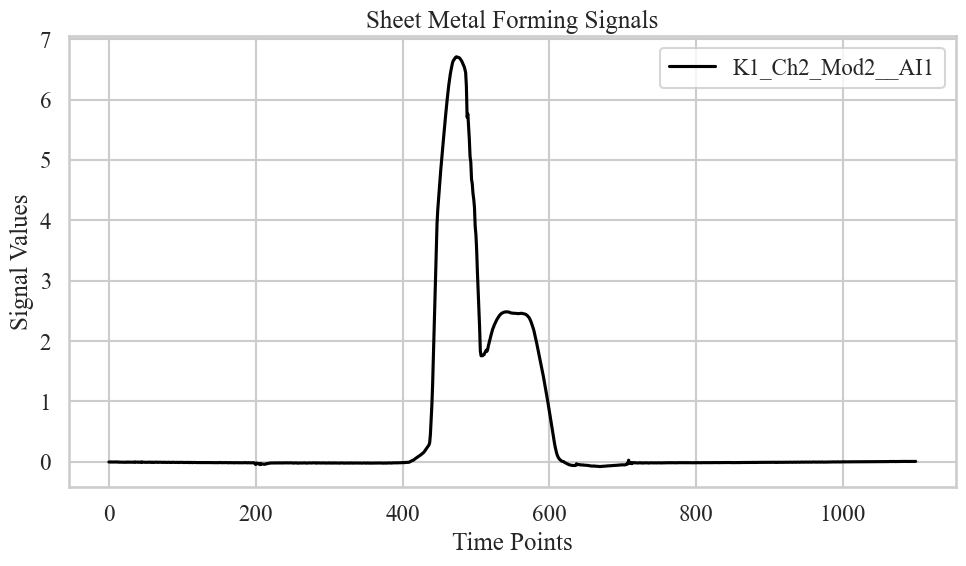

In [35]:
# Show one instance
sample = data_module.train_dataset[0]
print("Sample data shape:", sample["data"].shape)
print("Sample Deep Drawing:", sample["Deep Drawing"].item())
print("Sample Ironing:", sample["Ironing"].item())
plt.figure(figsize=(10, 6))
for i, signal in enumerate(data_module.signal_keys):
    plt.plot(sample["data"][i].numpy(), label=signal)
plt.title("Sheet Metal Forming Signals")
plt.xlabel("Time Points")
plt.ylabel("Signal Values")
plt.legend()
plt.tight_layout()
plt.savefig(plot_path / "sample_signals.pdf", bbox_inches="tight")
print(f"Saved plot to {plot_path / 'sample_signals.pdf'}")
plt.show()

Saved plot to /workspaces/sheet-metal-forming-measurement-comparison/plots/Ironing-from-Strip Connection Cut (Direct)/label_distribution.pdf


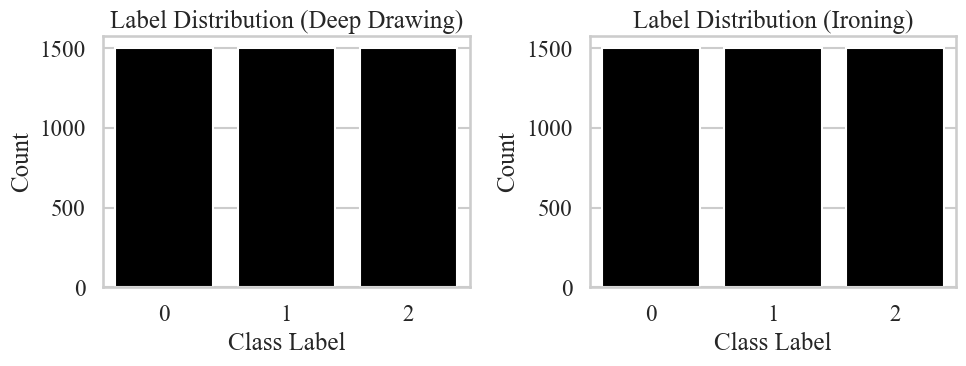

In [36]:
# Plot class label frequencies for Deep Drawing and Ironing
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, label in zip(axes, ["Deep Drawing", "Ironing"]):
    all_labels = torch.cat([
        getattr(data_module.train_dataset, label.lower().replace(" ", "_")),
        getattr(data_module.val_dataset, label.lower().replace(" ", "_")),
        getattr(data_module.test_dataset, label.lower().replace(" ", "_")),
    ])
    unique, counts = torch.unique(all_labels, return_counts=True)
    freq = counts.float()
    sns.barplot(x=unique.numpy(), y=freq.numpy(), ax=ax)
    ax.set_title(f"Label Distribution ({label})")
    ax.set_xlabel("Class Label")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.savefig(plot_path / "label_distribution.pdf", bbox_inches="tight")
print(f"Saved plot to {plot_path / 'label_distribution.pdf'}")
plt.show()

In [37]:
# Train a simple 1d-CNN to predict Deep Drawing and Ironing from signals

def conv_block(in_ch, out_ch, kernel_size, pool_size, dropout):
    return torch.nn.Sequential(
        torch.nn.Conv1d(in_ch, out_ch, kernel_size, padding=kernel_size // 2),
        torch.nn.BatchNorm1d(out_ch),
        torch.nn.ReLU(),
        torch.nn.MaxPool1d(pool_size),
        torch.nn.Dropout(dropout),
    )


class SimpleCNN(LightningModule):
    def __init__(self, n_signals: int, classification_target: ClassificationTarget, lr: float = 5e-4, dropout: float = 0.25):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.classification_target = classification_target
        n_classes = {
            "Deep Drawing": data_module.train_dataset.deep_drawing.unique().numel(),
            "Ironing": data_module.train_dataset.ironing.unique().numel(),
        }

        # 1100 -> 550 -> 137 -> 34 -> 8 -> 1 (AdaptiveAvgPool handles variable input)
        self.backbone = torch.nn.Sequential(
            conv_block(n_signals, 32, kernel_size=7,
                       pool_size=2, dropout=dropout * 0.5),
            conv_block(32, 64, kernel_size=5, pool_size=4,
                       dropout=dropout * 0.5),
            conv_block(64, 128, kernel_size=5, pool_size=4, dropout=dropout),
            conv_block(128, 256, kernel_size=3, pool_size=4, dropout=dropout),
            torch.nn.AdaptiveAvgPool1d(1),
            torch.nn.Flatten(),
            torch.nn.Dropout(dropout),
        )

        # Create heads based on classification target
        targets_to_track = []
        if classification_target in [ClassificationTarget.DeepDrawing, ClassificationTarget.Both]:
            self.head_deep_drawing = torch.nn.Linear(
                256, n_classes["Deep Drawing"])
            targets_to_track.append("Deep Drawing")
        else:
            self.head_deep_drawing = None

        if classification_target in [ClassificationTarget.Ironing, ClassificationTarget.Both]:
            self.head_ironing = torch.nn.Linear(256, n_classes["Ironing"])
            targets_to_track.append("Ironing")
        else:
            self.head_ironing = None

        self.criterion = torch.nn.CrossEntropyLoss()

        # Metrics for each stage and label
        for stage in ["train", "val", "test"]:
            for label in targets_to_track:
                num_classes = n_classes[label]
                setattr(self, f"{stage}_acc_{label.lower().replace(' ', '_')}",
                        torchmetrics.Accuracy(task="multiclass", num_classes=num_classes))
                setattr(self, f"{stage}_f1_{label.lower().replace(' ', '_')}",
                        torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro"))

    def forward(self, x):
        features = self.backbone(x)

        # Return outputs based on classification target
        if self.classification_target == ClassificationTarget.Both:
            return self.head_deep_drawing(features), self.head_ironing(features)
        elif self.classification_target == ClassificationTarget.DeepDrawing:
            return self.head_deep_drawing(features), None
        else:  # ClassificationTarget.Ironing
            return None, self.head_ironing(features)

    def _step(self, batch, stage: str):
        data, deep_drawing, ironing = batch["data"], batch["Deep Drawing"], batch["Ironing"]
        deep_drawing_out, ironing_out = self(data)

        # Compute loss only for active targets
        loss = 0.0
        if self.classification_target in [ClassificationTarget.DeepDrawing, ClassificationTarget.Both]:
            loss += self.criterion(deep_drawing_out, deep_drawing)
        if self.classification_target in [ClassificationTarget.Ironing, ClassificationTarget.Both]:
            loss += self.criterion(ironing_out, ironing)

        # Update and log metrics only for active targets
        if self.classification_target in [ClassificationTarget.DeepDrawing, ClassificationTarget.Both]:
            acc = getattr(self, f"{stage}_acc_deep_drawing")
            f1 = getattr(self, f"{stage}_f1_deep_drawing")
            acc(deep_drawing_out, deep_drawing)
            f1(deep_drawing_out, deep_drawing)
            self.log(f"{stage}_acc_Deep Drawing",
                     acc, prog_bar=(stage != "train"))
            self.log(f"{stage}_f1_Deep Drawing", f1,
                     prog_bar=(stage != "train"))

        if self.classification_target in [ClassificationTarget.Ironing, ClassificationTarget.Both]:
            acc = getattr(self, f"{stage}_acc_ironing")
            f1 = getattr(self, f"{stage}_f1_ironing")
            acc(ironing_out, ironing)
            f1(ironing_out, ironing)
            self.log(f"{stage}_acc_Ironing", acc, prog_bar=(stage != "train"))
            self.log(f"{stage}_f1_Ironing", f1, prog_bar=(stage != "train"))

        self.log(f"{stage}_loss", loss, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._step(batch, "test")

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)


# Check label ranges
train_deep_drawing = data_module.train_dataset.deep_drawing
train_ironing = data_module.train_dataset.ironing
print(f"Deep Drawing: {train_deep_drawing.min().item()}-{train_deep_drawing.max().item()}, Ironing: {train_ironing.min().item()}-{train_ironing.max().item()}")

model = SimpleCNN(
    n_signals=len(data_module.signal_keys),
    classification_target=classification_target,
)

Deep Drawing: 0-2, Ironing: 0-2


In [38]:
# Show data shapes through the model
from torchinfo import summary

# Get input shape from data
sample_batch = next(iter(data_module.train_dataloader()))
input_shape = sample_batch["data"].shape  # (batch, n_signals, n_points)

summary(model, input_size=input_shape, col_names=[
        "input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SimpleCNN                                [32, 1, 1100]             --                        --
├─Sequential: 1-1                        [32, 1, 1100]             [32, 256]                 --
│    └─Sequential: 2-1                   [32, 1, 1100]             [32, 32, 550]             --
│    │    └─Conv1d: 3-1                  [32, 1, 1100]             [32, 32, 1100]            256
│    │    └─BatchNorm1d: 3-2             [32, 32, 1100]            [32, 32, 1100]            64
│    │    └─ReLU: 3-3                    [32, 32, 1100]            [32, 32, 1100]            --
│    │    └─MaxPool1d: 3-4               [32, 32, 1100]            [32, 32, 550]             --
│    │    └─Dropout: 3-5                 [32, 32, 550]             [32, 32, 550]             --
│    └─Sequential: 2-2                   [32, 32, 550]             [32, 64, 137]             --
│    │    └─Conv1d: 3-6           

In [39]:
# Initialize WandB logger for learning curve tracking
# Create tags for filtering experiments: signal channels + classification target
wandb_tags = [f"signal_{ch}" for ch in signal_only_channels]
# e.g., "deepdrawing", "ironing", "both"
wandb_tags.append(classification_target.name.lower())

wandb_logger = WandbLogger(
    project="sheet-metal-forming",
    name="SimpleCNN",
    group=wandb_group,  # Optional group name for organizing experiments
    tags=wandb_tags,
    log_model=False,
    save_dir="wandb",
)

# Log hyperparameters
wandb_logger.experiment.config.update({
    "signal_only_channels": signal_only_channels,
    "classification_target": classification_target.value,
    "n_signals": len(data_module.signal_keys),
    "batch_size": data_module.batch_size,
    "train_samples": len(data_module.train_dataset),
    "val_samples": len(data_module.val_dataset),
    "test_samples": len(data_module.test_dataset),
})

trainer = Trainer(
    max_epochs=2,
    accelerator="auto",
    devices="auto",
    precision="bf16-mixed",
    # fast_dev_run=True,  # Set to False to run full training
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min",
                      patience=5, verbose=True),
        ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1),
    ],
    logger=wandb_logger,
)
trainer.fit(model, datamodule=data_module)

print()  # Blank line for readability
print("Load the best model after training")
model = SimpleCNN.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path, weights_only=False)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded 4500 samples from /workspaces/sheet-metal-forming-measurement-comparison/data/all_data.hdf5


/usr/local/lib/python3.13/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name              ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ backbone          │ Sequential         │  151 K │ train │     0 │
│ 1 │ head_ironing      │ Linear             │    771 │ train │     0 │
│ 2 │ criterion         │ CrossEntropyLoss   │      0 │ train │     0 │
│ 3 │ train_acc_ironing │ MulticlassAccuracy │      0 │ train │     0 │
│ 4 │ train_f1_ironing  │ MulticlassF1Score  │      0 │ train │     0 │
│ 5 │ val_acc_ironing   │ MulticlassAccuracy │      0 │ train │     0 │
│ 6 │ val_f1_ironing    │ MulticlassF1Score  │      0 │ train │     0 │
│ 7 │ test_acc_ironing  │ MulticlassAccuracy │      0 │ train │     0 │
│ 8 │ test_f1_ironing   │ MulticlassF1Score  │      0 │ train │     0 │
└───┴───────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 151 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 151 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 36                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)`
is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.

Metric val_loss improved. New best score: 1.091


Metric val_loss improved by 0.128 >= min_delta = 0.0. New best score: 0.963
`Trainer.fit` stopped: `max_epochs=2` reached.



Load the best model after training


In [40]:
test_results = trainer.test(model, datamodule=data_module)
print("Test results:", test_results)

# Save test results to text file
results_file = plot_path / "test_results.txt"
with open(results_file, "w") as f:
    f.write("=" * 80 + "\n")
    f.write("Test Results for Sheet Metal Forming Model\n")
    f.write("=" * 80 + "\n\n")

    f.write("Configuration:\n")
    f.write(f"  Channels Used: {signal_only_channels}\n")
    f.write(f"  Classification Target: {classification_target.value}\n")
    f.write(f"  Number of Signals: {len(data_module.signal_keys)}\n")
    f.write(f"  Signal Keys: {data_module.signal_keys}\n\n")

    f.write("Dataset Sizes:\n")
    f.write(f"  Train: {len(data_module.train_dataset)}\n")
    f.write(f"  Validation: {len(data_module.val_dataset)}\n")
    f.write(f"  Test: {len(data_module.test_dataset)}\n\n")

    f.write("Test Performance:\n")
    f.write("-" * 80 + "\n")
    for result_dict in test_results:
        for metric_name, value in sorted(result_dict.items()):
            f.write(f"  {metric_name:30s}: {value:.6f}\n")
    f.write("=" * 80 + "\n")

print(f"\nSaved test results to {results_file}")

# Finish the wandb run
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded 4500 samples from /workspaces/sheet-metal-forming-measurement-comparison/data/all_data.hdf5


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_acc_Ironing      │     0.425555557012558     │
│      test_f1_Ironing      │    0.34021687507629395    │
│         test_loss         │    0.9697368741035461     │
└───────────────────────────┴───────────────────────────┘

Test results: [{'test_acc_Ironing': 0.425555557012558, 'test_f1_Ironing': 0.34021687507629395, 'test_loss': 0.9697368741035461}]

Saved test results to /workspaces/sheet-metal-forming-measurement-comparison/plots/Ironing-from-Strip Connection Cut (Direct)/test_results.txt


epoch,▁▁▅▅▅█
test_acc_Ironing,▁
test_f1_Ironing,▁
test_loss,▁
train_acc_Ironing,▁▇█
train_f1_Ironing,▁▇█
train_loss,█▅▁
trainer/global_step,▁▃▃▆██
val_acc_Ironing,▁█
val_f1_Ironing,▁█
+1,...


In [41]:
# Attribution analysis using Captum Integrated Gradients
from captum.attr import IntegratedGradients
from tqdm.auto import tqdm

# Put model in eval mode and move to GPU if available
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Computing attributions on: {device}")

# Create wrapper functions for each head (Captum needs single output)
# and IG instances based on classification target
ig_instances = {}
all_attributions = {}  # Store absolute values for aggregate plots
all_attributions_signed = {}  # Store signed values for colored time series

if classification_target in [ClassificationTarget.DeepDrawing, ClassificationTarget.Both]:
    def forward_deep_drawing(x):
        return model(x)[0]
    ig_instances["Deep Drawing"] = IntegratedGradients(forward_deep_drawing)
    all_attributions["Deep Drawing"] = []
    all_attributions_signed["Deep Drawing"] = []

if classification_target in [ClassificationTarget.Ironing, ClassificationTarget.Both]:
    def forward_ironing(x):
        return model(x)[1]
    ig_instances["Ironing"] = IntegratedGradients(forward_ironing)
    all_attributions["Ironing"] = []
    all_attributions_signed["Ironing"] = []

# Process all test samples in batches
test_loader = data_module.test_dataloader()

print(
    f"Computing attributions over {len(data_module.test_dataset)} test samples for {classification_target.value}...")
for test_batch in tqdm(test_loader, desc="Computing attributions"):
    inputs = test_batch["data"].to(device)
    targets = {
        "Deep Drawing": test_batch["Deep Drawing"].to(device),
        "Ironing": test_batch["Ironing"].to(device),
    }

    # Baseline is zeros (no signal)
    baseline = torch.zeros_like(inputs)

    # Compute attributions for active targets
    for target_name, ig in ig_instances.items():
        attr = ig.attribute(inputs, baselines=baseline,
                            target=targets[target_name])
        # Store both signed and absolute versions (move to CPU to save GPU memory)
        all_attributions_signed[target_name].append(attr.cpu())
        all_attributions[target_name].append(attr.abs().cpu())

# Concatenate all attributions and normalize
normalized_attributions = {}
percentiles = {}
EPS = 1e-9

for target_name in all_attributions.keys():
    # Process absolute attributions for aggregate plots
    all_attr = torch.cat(all_attributions[target_name], dim=0)

    # Normalize each sample across all dimensions (n_signals x n_timepoints)
    # so that each sample's total attribution sums to 1, preserving probabilistic interpretation
    all_attr_normalized = all_attr / \
        (all_attr.sum(dim=(1, 2), keepdim=True) + EPS)

    # Average normalized attributions across samples
    avg_attr = all_attr_normalized.mean(dim=0).detach().numpy()

    # Compute percentiles for distribution-free uncertainty bands
    q10_attr = np.percentile(all_attr_normalized.numpy(), 10, axis=0)
    q90_attr = np.percentile(all_attr_normalized.numpy(), 90, axis=0)

    # Also store signed attributions (not normalized by magnitude, just raw)
    all_attr_signed = torch.cat(all_attributions_signed[target_name], dim=0)

    normalized_attributions[target_name] = {
        "all": all_attr_normalized,  # Absolute, normalized
        "all_signed": all_attr_signed,  # Signed, not normalized
        "mean": avg_attr,
        "q10": q10_attr,
        "q90": q90_attr,
    }

n_samples = len(data_module.test_dataset)
print(
    f"Attribution shape: {list(all_attributions.values())[0][0].shape if all_attributions else 'N/A'}")
print(
    f"Computed attributions for targets: {list(normalized_attributions.keys())}")

Computing attributions on: cuda
Computing attributions over 900 test samples for Ironing...


Computing attributions:   0%|          | 0/29 [00:00<?, ?it/s]

Attribution shape: torch.Size([32, 1, 1100])
Computed attributions for targets: ['Ironing']


Saved plot to /workspaces/sheet-metal-forming-measurement-comparison/plots/Ironing-from-Strip Connection Cut (Direct)/attribution_time_domain.pdf


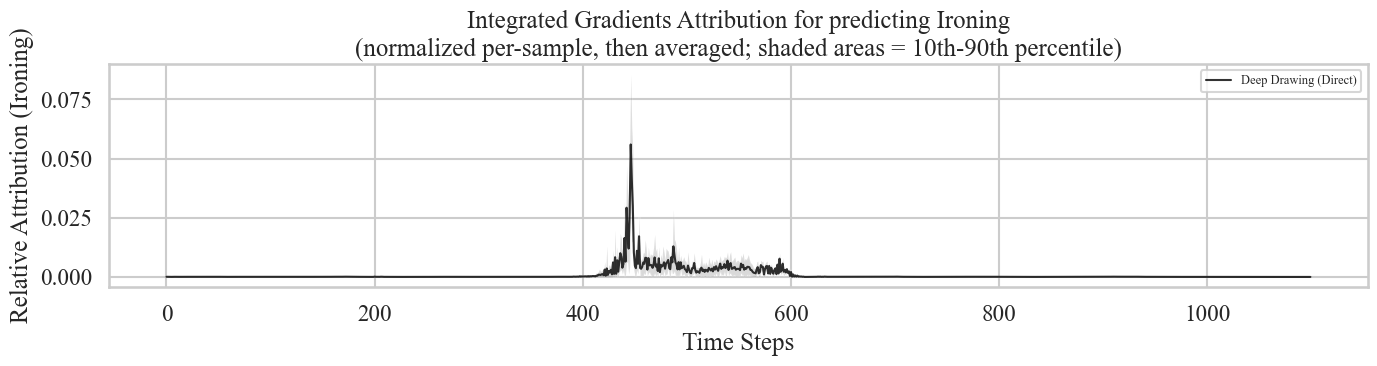

Saved plot to /workspaces/sheet-metal-forming-measurement-comparison/plots/Ironing-from-Strip Connection Cut (Direct)/attribution_signal_importance.pdf


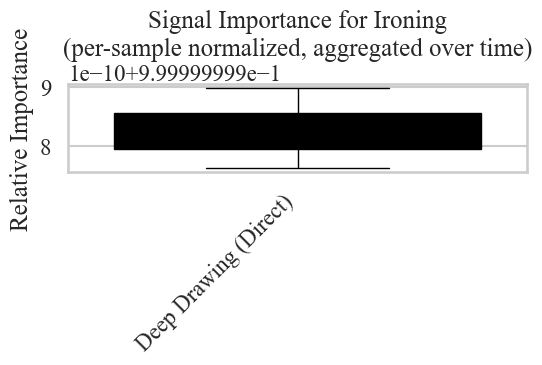

In [42]:
# Visualize attributions with 10-90 percentile bands
# Normalization: each sample normalized across all (n_signals, n_timepoints),
# then averaged across samples with percentile-based uncertainty bands (distribution-free)

n_targets = len(normalized_attributions)
fig, axes = plt.subplots(n_targets, 1, figsize=(
    14, 4 * n_targets), sharex=True)

# Handle case where there's only one target
if n_targets == 1:
    axes = [axes]

for ax, (target_name, attr_data) in zip(axes, normalized_attributions.items()):
    attr = attr_data["mean"]
    q10 = attr_data["q10"]
    q90 = attr_data["q90"]

    # attr already normalized at sample level, then averaged
    # q10/q90 show where 80% of samples fall (10th-90th percentile - robust to non-normal distributions)
    for i, signal_name in enumerate(data_module.signal_keys):
        readable_name = CHANNEL_MAPPING[signal_name]

        # Plot mean
        ax.plot(attr[i], label=readable_name, alpha=0.8, linewidth=1.5)

        # Add 10-90 percentile band
        ax.fill_between(range(len(attr[i])), q10[i], q90[i], alpha=0.15)

    ax.set_ylabel(f"Relative Attribution ({target_name})")
    ax.set_title(
        f"Integrated Gradients Attribution for predicting {target_name}\n(normalized per-sample, then averaged; shaded areas = 10th-90th percentile)")
    ax.legend(loc="upper right", fontsize=9)

axes[-1].set_xlabel("Time Steps")
plt.tight_layout()
plt.savefig(plot_path / "attribution_time_domain.pdf", bbox_inches="tight")
print(f"Saved plot to {plot_path / 'attribution_time_domain.pdf'}")
plt.show()

# Aggregated relative importance per signal (box plots)
# Per-sample aggregation: sum over time, then normalize per sample
n_targets = len(normalized_attributions)
fig, axes = plt.subplots(1, n_targets, figsize=(6 * n_targets, 4))

# Handle case where there's only one target
if n_targets == 1:
    axes = [axes]

for ax, (target_name, attr_data) in zip(axes, normalized_attributions.items()):
    all_attr_normalized = attr_data["all"]

    # Sum normalized attribution over time per sample
    # (already normalized at sample level, so this shows signal-level relative importance)
    per_sample_importance = all_attr_normalized.sum(dim=2)

    labels = [CHANNEL_MAPPING[key] for key in data_module.signal_keys]
    # Move to NumPy for seaborn
    data_np = per_sample_importance.cpu().numpy()

    sns.boxplot(data=[data_np[:, i]
                for i in range(data_np.shape[1])], ax=ax, whis=1.5)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylabel("Relative Importance")
    ax.set_title(
        f"Signal Importance for {target_name}\n(per-sample normalized, aggregated over time)")

plt.tight_layout()
plt.savefig(plot_path / "attribution_signal_importance.pdf",
            bbox_inches="tight")
print(f"Saved plot to {plot_path / 'attribution_signal_importance.pdf'}")
plt.show()

Saved plot to /workspaces/sheet-metal-forming-measurement-comparison/plots/Ironing-from-Strip Connection Cut (Direct)/attribution_fft_full.pdf


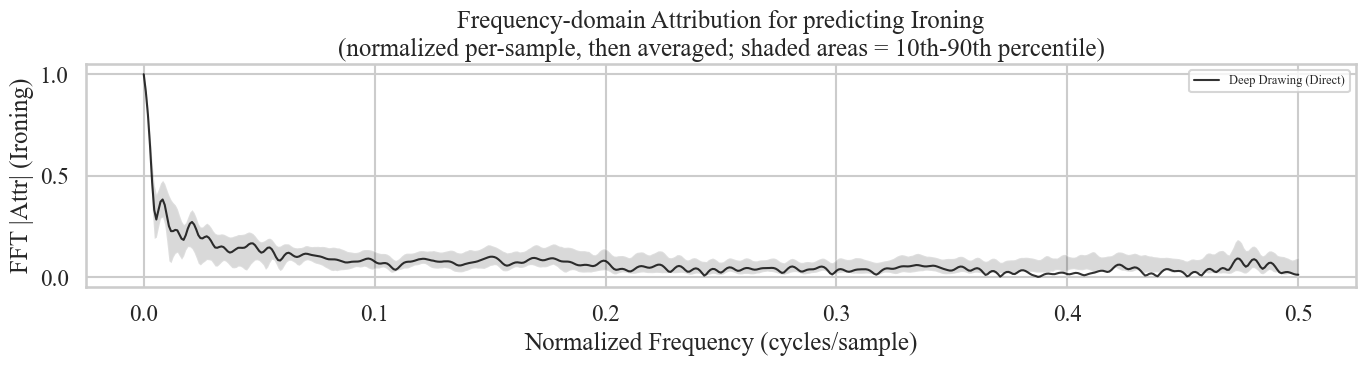

In [43]:
# Frequency-domain view of attributions (FFT)
# Using per-sample normalized attributions then averaged
from numpy.fft import rfft, rfftfreq

# Compute FFT for each target
fft_attributions = {}

for target_name, attr_data in normalized_attributions.items():
    # Use the first signal's length for frequency calculation
    freqs = rfftfreq(attr_data["mean"].shape[1], d=1.0)

    # FFT of mean attribution
    fft_attr = np.abs(rfft(attr_data["mean"], axis=1))

    # FFT of all samples for percentiles
    fft_attr_all = np.abs(rfft(attr_data["all"].numpy(), axis=2))
    q10_fft = np.percentile(fft_attr_all, 10, axis=0)
    q90_fft = np.percentile(fft_attr_all, 90, axis=0)

    fft_attributions[target_name] = {
        "freqs": freqs,
        "mean": fft_attr,
        "q10": q10_fft,
        "q90": q90_fft,
    }

n_targets = len(fft_attributions)
fig, axes = plt.subplots(n_targets, 1, figsize=(
    14, 4 * n_targets), sharex=True)

# Handle case where there's only one target
if n_targets == 1:
    axes = [axes]

for ax, (target_name, fft_data) in zip(axes, fft_attributions.items()):
    freqs = fft_data["freqs"]
    fft_attr = fft_data["mean"]
    q10_fft = fft_data["q10"]
    q90_fft = fft_data["q90"]

    for i, signal_name in enumerate(data_module.signal_keys):
        readable_name = CHANNEL_MAPPING[signal_name]

        # Plot mean
        ax.plot(freqs, fft_attr[i], label=readable_name,
                alpha=0.8, linewidth=1.5)

        # Add 10-90 percentile band
        ax.fill_between(freqs, q10_fft[i], q90_fft[i], alpha=0.15)

    ax.set_ylabel(f"FFT |Attr| ({target_name})")
    ax.set_title(
        f"Frequency-domain Attribution for predicting {target_name}\n(normalized per-sample, then averaged; shaded areas = 10th-90th percentile)")
    ax.legend(loc="upper right", fontsize=9)

axes[-1].set_xlabel("Normalized Frequency (cycles/sample)")
plt.tight_layout()
plt.savefig(plot_path / "attribution_fft_full.pdf", bbox_inches="tight")
print(f"Saved plot to {plot_path / 'attribution_fft_full.pdf'}")
plt.show()

Saved plot to /workspaces/sheet-metal-forming-measurement-comparison/plots/Ironing-from-Strip Connection Cut (Direct)/attribution_fft_lowfreq.pdf


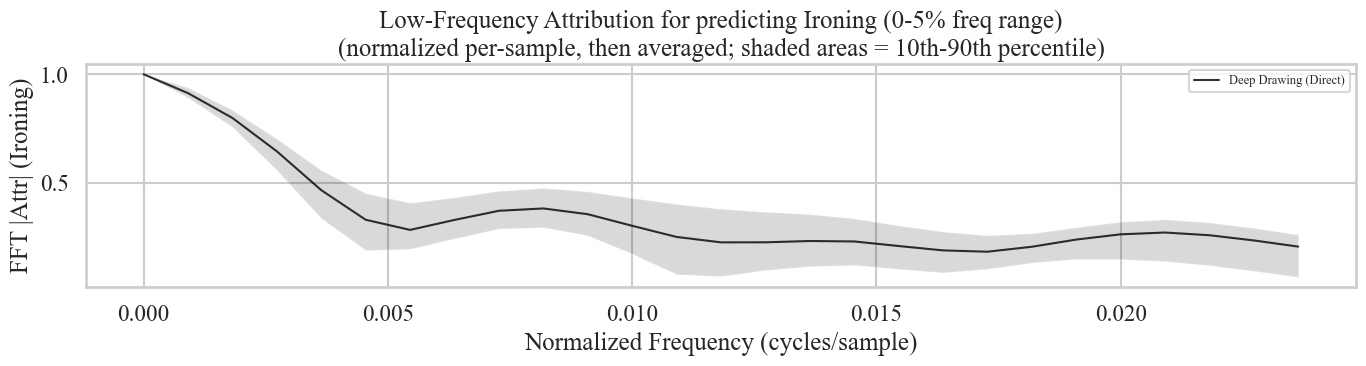

In [44]:
# Zoomed-in view of low-frequency FFT attribution (first 5%)
freq_cutoff_pct = 0.05

n_targets = len(fft_attributions)
fig, axes = plt.subplots(n_targets, 1, figsize=(
    14, 4 * n_targets), sharex=True)

# Handle case where there's only one target
if n_targets == 1:
    axes = [axes]

for ax, (target_name, fft_data) in zip(axes, fft_attributions.items()):
    freqs = fft_data["freqs"]
    fft_attr = fft_data["mean"]
    q10_fft = fft_data["q10"]
    q90_fft = fft_data["q90"]

    freq_cutoff_idx = int(len(freqs) * freq_cutoff_pct)

    for i, signal_name in enumerate(data_module.signal_keys):
        readable_name = CHANNEL_MAPPING[signal_name]

        # Plot mean in low-frequency range
        ax.plot(freqs[:freq_cutoff_idx], fft_attr[i, :freq_cutoff_idx],
                label=readable_name, alpha=0.8, linewidth=1.5)

        # Add 10-90 percentile band
        ax.fill_between(freqs[:freq_cutoff_idx], q10_fft[i, :freq_cutoff_idx],
                        q90_fft[i, :freq_cutoff_idx], alpha=0.15)

    ax.set_ylabel(f"FFT |Attr| ({target_name})")
    ax.set_title(
        f"Low-Frequency Attribution for predicting {target_name} (0-{int(freq_cutoff_pct*100)}% freq range)\n(normalized per-sample, then averaged; shaded areas = 10th-90th percentile)")
    ax.legend(loc="upper right", fontsize=9)

axes[-1].set_xlabel("Normalized Frequency (cycles/sample)")
plt.tight_layout()
plt.savefig(plot_path / "attribution_fft_lowfreq.pdf", bbox_inches="tight")
print(f"Saved plot to {plot_path / 'attribution_fft_lowfreq.pdf'}")
plt.show()

In [45]:
# Attribution Visualization: Time Series with Attribution-Colored Points
# Inspired by attr/plot_mean_attributions.py
# Shows the actual signal values with attribution intensity as color

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

# Get a sample from each class for visualization
# We'll show one example per target (Deep Drawing level or Ironing level)
sample_indices_per_class = {}

for target_name in normalized_attributions.keys():
    # Get 3 samples per class (levels 0, 1, 2)
    sample_indices_per_class[target_name] = {}

    test_loader_single = torch.utils.data.DataLoader(
        data_module.test_dataset,
        batch_size=1,
        shuffle=False
    )

    # Find one sample from each class
    class_samples_found = {0: None, 1: None, 2: None}

    for idx, batch in enumerate(test_loader_single):
        if target_name == "Deep Drawing":
            class_label = batch["Deep Drawing"].item()
        else:  # Ironing
            class_label = batch["Ironing"].item()

        if class_label in class_samples_found and class_samples_found[class_label] is None:
            class_samples_found[class_label] = idx

        # Stop if we found all 3 classes
        if all(v is not None for v in class_samples_found.values()):
            break

    sample_indices_per_class[target_name] = class_samples_found

print(f"Found sample indices for each class:")
for target_name, indices in sample_indices_per_class.items():
    print(f"  {target_name}: {indices}")

Found sample indices for each class:
  Ironing: {0: 1, 1: 0, 2: 2}


Saved colored time series plot to /workspaces/sheet-metal-forming-measurement-comparison/plots/Ironing-from-Strip Connection Cut (Direct)/attribution_colored_timeseries_ironing.pdf


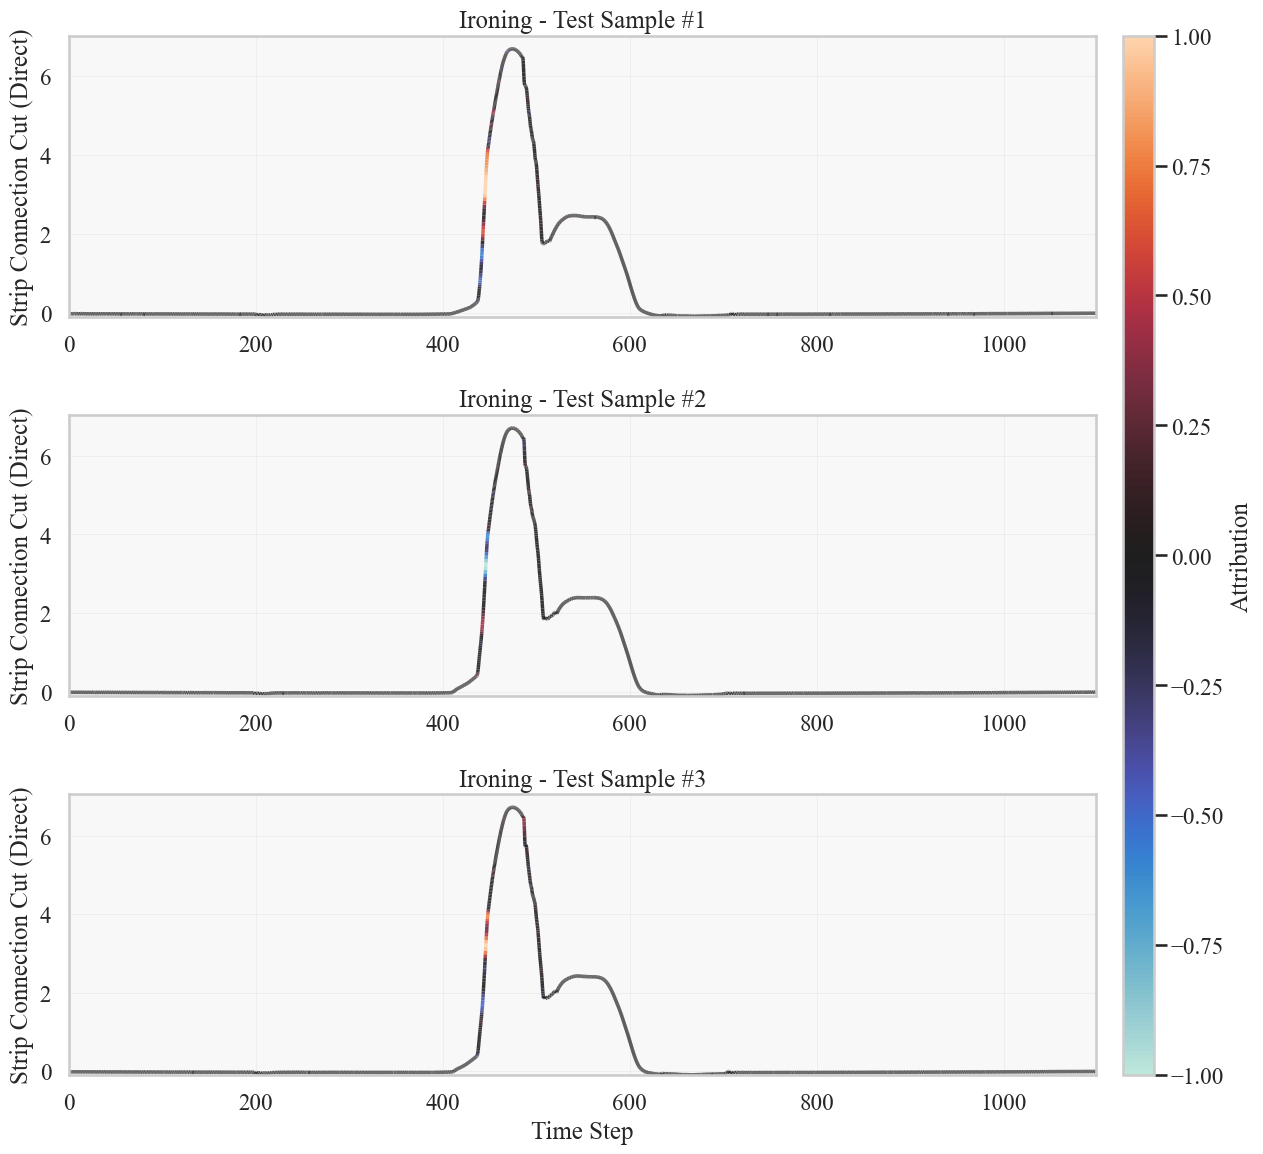

In [46]:
# Create colored time series plots for each target
# Using LineCollection to color the line segments based on attribution
# Uses SIGNED attributions (not absolute) to show positive vs negative contributions
from matplotlib.collections import LineCollection
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates.
    Returns array of shape: (n_segments, 2 points, 2 coordinates)
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


for target_name in normalized_attributions.keys():
    attr_data = normalized_attributions[target_name]

    # Get SIGNED attribution data (not absolute!)
    # Shape: (n_test_samples, n_signals, n_timepoints)
    all_attr_signed = attr_data['all_signed'].numpy()

    # Create figure with GridSpec: main plots + colorbar column
    n_classes = 3
    fig = plt.figure(figsize=(14, 4.5 * n_classes))
    gs = GridSpec(n_classes, 2, width_ratios=[1, 0.03], wspace=0.05, hspace=0.35)
    
    axes = [fig.add_subplot(gs[i, 0]) for i in range(n_classes)]
    cbar_ax = fig.add_subplot(gs[:, 1])  # Colorbar spans all rows

    class_labels = ['Level 1', 'Level 2', 'Level 3']
    
    # Determine y-axis label: use signal name for single channel, "Signal Value" for multiple
    is_single_signal = len(signal_only_channels_readable) == 1
    y_label = signal_only_channels_readable[0] if is_single_signal else 'Signal Value'

    for class_idx, ax in enumerate(axes):
        # Get the sample index for this class
        sample_idx = sample_indices_per_class[target_name][class_idx]

        if sample_idx is None:
            ax.text(0.5, 0.5, f'No sample found for {class_labels[class_idx]}',
                    ha='center', va='center', transform=ax.transAxes)
            continue

        # Get the actual signal data for this sample
        sample_data = data_module.test_dataset[sample_idx]['data'].numpy()

        # Get the SIGNED attribution for this sample
        # Shape: (n_signals, n_timepoints)
        sample_attr_signed = all_attr_signed[sample_idx]

        # Find global min/max for consistent y-axis across all signals
        y_min = sample_data.min()
        y_max = sample_data.max()

        # Plot each signal with colored line segments
        for signal_idx, signal_name in enumerate(signal_only_channels_readable):

            signal_values = sample_data[signal_idx]
            signal_attr_signed = sample_attr_signed[signal_idx]

            # Original time points
            time_points_orig = np.arange(len(signal_values))

            # Interpolate to create smoother line segments (5x more points)
            interp_factor = 5
            time_points_interp = np.linspace(
                0, len(signal_values) - 1, len(signal_values) * interp_factor)

            # Interpolate signal values
            f_signal = interp1d(time_points_orig, signal_values, kind='cubic')
            signal_values_interp = f_signal(time_points_interp)

            # Interpolate SIGNED attributions
            f_attr = interp1d(time_points_orig,
                              signal_attr_signed, kind='cubic')
            signal_attr_signed_interp = f_attr(time_points_interp)

            # Normalize signed attributions symmetrically around zero for diverging colormap
            # Find the maximum absolute value across all signals for this sample for consistent scaling
            attr_max_abs = np.abs(sample_attr_signed).max() + 1e-9
            attr_normalized = signal_attr_signed_interp / attr_max_abs
            # Clip to [-1, 1] range for colormap
            attr_normalized = np.clip(attr_normalized, -1.0, 1.0)

            # Create line segments from interpolated data
            segments = make_segments(time_points_interp, signal_values_interp)

            # Create LineCollection with attribution-based colors using 'icefire' diverging colormap
            # icefire: blue (negative) -> white/yellow (zero) -> orange/red (positive)
            lc = LineCollection(
                segments,
                array=attr_normalized[:-1],  # One color per segment
                cmap='icefire',
                norm=plt.Normalize(-1.0, 1.0),  # Symmetric around zero
                linewidth=2.5,
                alpha=0.9
            )

            ax.add_collection(lc)

        # Set axis limits
        ax.set_xlim(0, len(time_points_orig) - 1)
        ax.set_ylim(y_min * 1.05, y_max * 1.05)

        # Title with 1-indexed sequential numbering
        ax.set_title(f'{target_name} - Test Sample #{class_idx + 1}')
        ax.set_ylabel(y_label)
        ax.set_facecolor('#f8f8f8')
        ax.grid(True, alpha=0.3, linewidth=0.5)
        
        # Only show x-label on bottom plot
        if class_idx == n_classes - 1:
            ax.set_xlabel('Time Step')

    # Add colorbar in dedicated axes
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    sm = plt.cm.ScalarMappable(cmap='icefire', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Attribution')

    # Save the plot
    filename_base = f"attribution_colored_timeseries_{target_name.lower().replace(' ', '_')}"
    plt.savefig(plot_path / f"{filename_base}.pdf",
                bbox_inches='tight', dpi=300)
    plt.savefig(plot_path / f"{filename_base}.png",
                bbox_inches='tight', dpi=150)
    print(f"Saved colored time series plot to {plot_path / filename_base}.pdf")

    plt.show()